# Measuring the Galaxy-LyaForest Cross-Correlation from CLAMATO DR2

Here, we carry out the first cross-correlation measurement of the Ly-alpha forest measured by CLAMATO DR2, and coeval galaxies from MOSDEF, 3D-HST and zCOSMOS-Deep (separately for each sample). We use the simple estimator from Font-Ribera+ 2012 DLA-Forest cross-correlation paper:

\begin{equation*}
\xi_A = \frac{\sum_{i\in A} w_i \delta_{Fi}}{\sum_{i\in A} w_i},
\end{equation*}

where 

\begin{equation*}
w_i =  \left[\sigma^2_F(z_i) + \frac{\sigma_{N,i}^2}{C_i^2 \bar{F}^2(z_i)}\right]^{-1}
\end{equation*}

and $\sigma_F^2(z_i) = 0.065 [(1+z_i)/3.25]^{3.8}$.

This uses the np.histogram2d function twice, to compute the numerator and denominator of the estimator around each galaxy.

The pixel data needs to be generated using the IDL script GEN_CROSSCORR_INPUT.PRO, and the mean-flux shoudl first be calculated with CALC_MEANFLUX.IPYNB

### Read in Ly-a forest pixels

RA limits are 149.87192 150.44998
Dec limits are 2.07213 2.49511
Read in 95748 Ly-a forest pixels


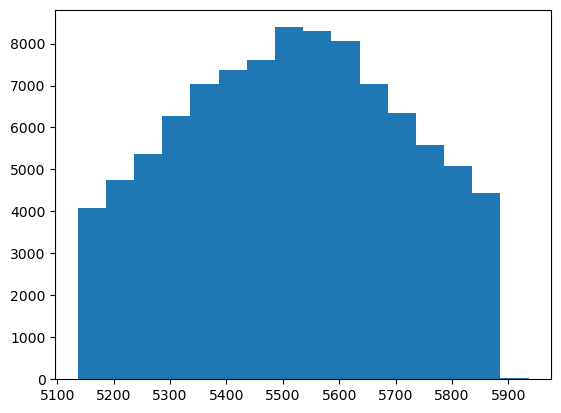

In [1]:
import numpy as np
import time as time
import os
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

def taueff_evo(z):
    return 0.001845 * (1.+z)**3.924

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

clamato_dir_base = 'data/clamato_dr2'
lyapix = xcorr.lyapix(os.path.join(clamato_dir_base, "pixel_radecz_cl2020_v0.bin") ,cosmo=cosmo)

print("Read in %i Ly-a forest pixels" % lyapix.npix)
npix = lyapix.npix

fig, ax = plt.subplots()
binwidth = 50
histdata = lyapix.coord.distance.value

ax.hist(histdata,bins=np.arange(min(histdata),max(histdata) + binwidth, binwidth))
plt.show()

# Carry out mean-flux correction
fmean_str = ascii.read(os.path.join(clamato_dir_base, 'fmean_measured_v0.dat'))
zmid = fmean_str['zmid']
F_mean = fmean_str['F_mean']

#Fcorr = np.interp(lyapix.z, zmid, F_mean) / np.exp(-taueff_evo(lyapix.z))
#lyapix.delta = ((1.+lyapix.delta)/np.exp(-taueff_evo(lyapix.z)))-1.


### Read in galaxies and generate randoms
We use the catalog created with GRAB_COEVAL_GAL.IPYNB

At the same time, also generate mock catalog 

In [2]:
gal_dir_base = 'data/coeval'
galfil = os.path.join(gal_dir_base, 'cat_galxcorr_cl2020_nonuniq_v0.dat')
gal = ascii.read(galfil, format='ipac')
#print(gal.columns)

gal_3d = gal[gal['source'] == '3DHST']
gal_zD = gal[gal['source'] == 'zDeep']
gal_mosdef = gal[gal['source'] == 'MOSDEF']
gal_vuds = gal[gal['source']=='VUDS']
gal_clamato=gal[gal['source']=='CLAMATO']

print('Read in %i 3D-HST galaxies, %i zCOSMOS-Deep galaxies, %i MOSDEF galaxies,' 
      '%i VUDS galaxies, %i CLAMATO galaxies' % 
      (len(gal_3d), len(gal_zD), len(gal_mosdef), len(gal_vuds),len(gal_clamato)) )

# Convert to 3D Sky positions
Coord_3d     = SkyCoord(ra=gal_3d['ra']  , dec=gal_3d['dec']  ,
                  distance=cosmo.comoving_distance(gal_3d['zspec']))
Coord_zD     = SkyCoord(ra=gal_zD['ra']  , dec=gal_zD['dec']  ,
                   distance=cosmo.comoving_distance(gal_zD['zspec']))
Coord_mosdef = SkyCoord(ra=gal_mosdef['ra']  , dec=gal_mosdef['dec']  ,
                   distance=cosmo.comoving_distance(gal_mosdef['zspec']))
Coord_vuds   = SkyCoord(ra=gal_vuds['ra']  , dec=gal_vuds['dec']  ,
                       distance=cosmo.comoving_distance(gal_vuds['zspec']))
Coord_clamato=SkyCoord(ra=gal_clamato['ra'], dec=gal_clamato['dec']  ,
                      distance=cosmo.comoving_distance(gal_clamato['zspec']))
Coord_all = SkyCoord(ra=gal['ra'], dec=gal['dec']  ,
                      distance=cosmo.comoving_distance(gal['zspec']))


# Specify random number seed
#np.random.seed(seed=12621137)
np.random.seed(seed=162345)

# Generate random galaxy positions that are within the same [RA,Dec,z] bounds as the real galaxies,
# but somewhat larger to suppress noise. 

nrand = 25

# 3D-HST randoms
gal_tmp = gal_3d
ra0_tmp = min(gal_tmp['ra'])
raran_tmp = max(gal_tmp['ra']) - min(gal_tmp['ra'])
dec0_tmp = min(gal_tmp['dec'])
decran_tmp = max(gal_tmp['dec']) - min(gal_tmp['dec'])
dist_tmp = cosmo.comoving_distance(gal_tmp['zspec'])
dist0_tmp = min(dist_tmp)
distran_tmp = max(dist_tmp) - min(dist_tmp)

ra_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*raran_tmp + ra0_tmp
dec_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*decran_tmp + dec0_tmp
dist_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*distran_tmp + dist0_tmp

Rand_3d = SkyCoord(ra=ra_rand_tmp*u.degree, dec=dec_rand_tmp*u.degree, 
                   distance=dist_rand_tmp)

# zCOSMOS-Deep randoms
gal_tmp = gal_zD
ra0_tmp = min(gal_tmp['ra'])
raran_tmp = max(gal_tmp['ra']) - min(gal_tmp['ra'])
dec0_tmp = min(gal_tmp['dec'])
decran_tmp = max(gal_tmp['dec']) - min(gal_tmp['dec'])
dist_tmp = cosmo.comoving_distance(gal_tmp['zspec'])
dist0_tmp = min(dist_tmp)
distran_tmp = max(dist_tmp) - min(dist_tmp)

ra_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*raran_tmp + ra0_tmp
dec_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*decran_tmp + dec0_tmp
dist_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*distran_tmp + dist0_tmp

Rand_zD = SkyCoord(ra=ra_rand_tmp*u.degree, dec=dec_rand_tmp*u.degree, 
                   distance=dist_rand_tmp)

# MOSDEF randoms
gal_tmp = gal_mosdef
ra0_tmp = min(gal_tmp['ra'])
raran_tmp = max(gal_tmp['ra']) - min(gal_tmp['ra'])
dec0_tmp = min(gal_tmp['dec'])
decran_tmp = max(gal_tmp['dec']) - min(gal_tmp['dec'])
dist_tmp = cosmo.comoving_distance(gal_tmp['zspec'])
dist0_tmp = min(dist_tmp)
distran_tmp = max(dist_tmp) - min(dist_tmp)

ra_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*raran_tmp + ra0_tmp
dec_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*decran_tmp + dec0_tmp
dist_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*distran_tmp + dist0_tmp

Rand_mosdef = SkyCoord(ra=ra_rand_tmp*u.degree, dec=dec_rand_tmp*u.degree, 
                   distance=dist_rand_tmp)

#VUDS randoms
gal_tmp = gal_vuds
ra0_tmp = min(gal_tmp['ra'])
raran_tmp = max(gal_tmp['ra']) - min(gal_tmp['ra'])
dec0_tmp = min(gal_tmp['dec'])
decran_tmp = max(gal_tmp['dec']) - min(gal_tmp['dec'])
dist_tmp = cosmo.comoving_distance(gal_tmp['zspec'])
dist0_tmp = min(dist_tmp)
distran_tmp = max(dist_tmp) - min(dist_tmp)

ra_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*raran_tmp + ra0_tmp
dec_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*decran_tmp + dec0_tmp
dist_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*distran_tmp + dist0_tmp

Rand_vuds = SkyCoord(ra=ra_rand_tmp*u.degree, dec=dec_rand_tmp*u.degree, 
                   distance=dist_rand_tmp)

#CLAMATO randoms
gal_tmp = gal_clamato
ra0_tmp = min(gal_tmp['ra'])
raran_tmp = max(gal_tmp['ra']) - min(gal_tmp['ra'])
dec0_tmp = min(gal_tmp['dec'])
decran_tmp = max(gal_tmp['dec']) - min(gal_tmp['dec'])
dist_tmp = cosmo.comoving_distance(gal_tmp['zspec'])
dist0_tmp = min(dist_tmp)
distran_tmp = max(dist_tmp) - min(dist_tmp)

ra_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*raran_tmp + ra0_tmp
dec_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*decran_tmp + dec0_tmp
dist_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*distran_tmp + dist0_tmp

Rand_clamato = SkyCoord(ra=ra_rand_tmp*u.degree, dec=dec_rand_tmp*u.degree, 
                   distance=dist_rand_tmp)

#Randoms for all
gal_tmp = gal
ra0_tmp = min(gal_tmp['ra'])
raran_tmp = max(gal_tmp['ra']) - min(gal_tmp['ra'])
dec0_tmp = min(gal_tmp['dec'])
decran_tmp = max(gal_tmp['dec']) - min(gal_tmp['dec'])
dist_tmp = cosmo.comoving_distance(gal_tmp['zspec'])
dist0_tmp = min(dist_tmp)
distran_tmp = max(dist_tmp) - min(dist_tmp)

ra_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*raran_tmp + ra0_tmp
dec_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*decran_tmp + dec0_tmp
dist_rand_tmp = np.random.random_sample(len(gal_tmp)*nrand)*distran_tmp + dist0_tmp

Rand_all = SkyCoord(ra=ra_rand_tmp*u.degree, dec=dec_rand_tmp*u.degree, 
                   distance=dist_rand_tmp)

Read in 322 3D-HST galaxies, 759 zCOSMOS-Deep galaxies, 195 MOSDEF galaxies,469 VUDS galaxies, 205 CLAMATO galaxies


### Read in bin edges 

In [3]:
xcorr_dir_base = 'data/xcorr'

PiBin_fil = os.path.join(xcorr_dir_base, 'bins23_pi_0-30hMpc.txt')
SigBin_fil = os.path.join(xcorr_dir_base, 'bins10_sigma_0-30hMpc.txt')

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])

print('Pi bin edges in Mpc:')
print(PiEdges)
print('Sigma bin edges in Mpc:')
print(SigEdges)


PiBound = (min(PiEdges), max(PiEdges) )

Pi bin edges in Mpc:
[-42.85714286 -35.71428571 -30.         -24.28571429 -18.57142857
 -14.28571429 -10.          -7.14285714  -5.          -2.85714286
  -1.42857143  -0.35714286   0.35714286   1.42857143   2.85714286
   5.           7.14285714  10.          14.28571429  18.57142857
  24.28571429  30.          35.71428571  42.85714286]
Sigma bin edges in Mpc:
[ 0.          1.          2.14285714  3.57142857  5.71428571 10.
 14.28571429 21.42857143 32.14285714 42.85714286]


### Compute Cross-Correlation For MOSDEF Galaxies


In [4]:
XCorr_mosdef, NoXCorr_mosdef = xcorr.xcorr_gal_lya(Coord_mosdef, lyapix, SigEdges, PiEdges, cosmo=cosmo)
XCorr_mosdef_rand, _ = xcorr.xcorr_gal_lya(Rand_mosdef, lyapix, SigEdges, PiEdges, cosmo=cosmo,verbose=0)

X, Y = np.meshgrid(SigEdges, PiEdges)

XCorrArr = np.rot90(XCorr_mosdef)
XCorrArr = np.flipud(XCorrArr)

XCorrRand = np.rot90(XCorr_mosdef_rand)
XCorrRand = np.flipud(XCorrRand)

Evaluating cross-correlation for 195 galaxies and 95748 forest pixels
2D histogram evaluation took 0.015682 seconds for first galaxy
Finished evaluating cross-correlations. This took 2.284183 seconds
0 galaxies had no cross-correlations within these bins.


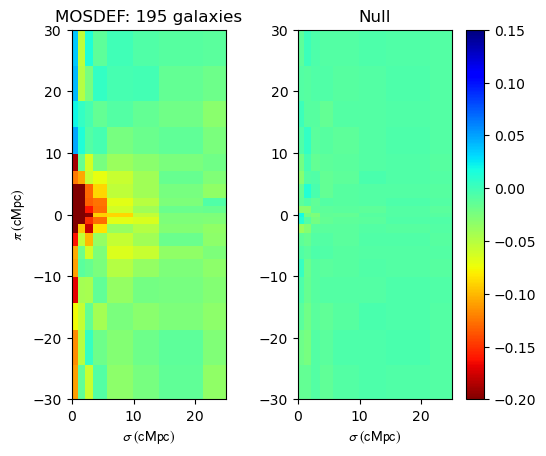

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2)

SigMax = 25.
PiMin = -30.
PiMax = 30.

pcm=ax1.pcolormesh(X, Y, XCorrArr,cmap='jet_r',vmin=-0.2, vmax=0.15 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("MOSDEF: %i galaxies" % len(gal_mosdef))

ax2.pcolormesh(X, Y, XCorrRand, cmap='jet_r',vmin=-0.2,vmax=0.15)
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_title("Null")

#fig.colorbar(pcm, ax=ax1)
fig.colorbar(pcm, ax=ax2)
fig.subplots_adjust(wspace=-0.2)

plt.show()


### Compute Cross-Correlation For zCOSMOS-Deep Galaxies

In [6]:
XCorr_zD, NoXCorr_zD = xcorr.xcorr_gal_lya(Coord_zD, lyapix, SigEdges, PiEdges,cosmo=cosmo)
XCorr_zD_rand, _ = xcorr.xcorr_gal_lya(Rand_zD, lyapix, SigEdges, PiEdges,cosmo=cosmo,verbose=0)

X, Y = np.meshgrid(SigEdges, PiEdges)

XCorrArr = np.rot90(XCorr_zD)
XCorrArr = np.flipud(XCorrArr)
XCorrRand = np.rot90(XCorr_zD_rand)
XCorrRand = np.flipud(XCorrRand)

Evaluating cross-correlation for 759 galaxies and 95748 forest pixels
2D histogram evaluation took 0.014740 seconds for first galaxy
Finished evaluating cross-correlations. This took 9.173477 seconds
0 galaxies had no cross-correlations within these bins.


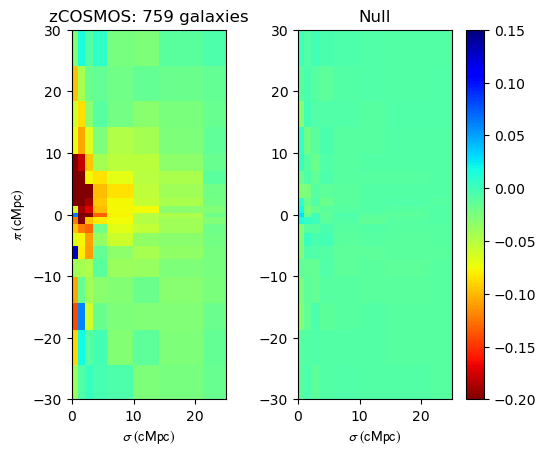

-0.008421237950852872


In [7]:
SigMax = 25.
PiMin = -30.
PiMax = 30.

fig, (ax1, ax2)= plt.subplots(1,2)

pcm=ax1.pcolormesh(X, Y, XCorrArr,cmap='jet_r',vmin=-0.2, vmax=0.15 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("zCOSMOS: %i galaxies" % len(gal_zD))

ax2.pcolormesh(X, Y, XCorrRand, cmap='jet_r',vmin=-0.2,vmax=0.15)
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_title("Null")

#fig.colorbar(pcm, ax=ax1)
fig.colorbar(pcm, ax=ax2)
fig.subplots_adjust(wspace=-0.2)

plt.show()

print(np.mean(XCorrRand))

### Compute Cross-Correlation for CLAMATO Galaxies

In [8]:
XCorr_clamato, NoXCorr_clamato = xcorr.xcorr_gal_lya(Coord_clamato, lyapix, SigEdges, PiEdges,cosmo=cosmo)
XCorr_clamato_rand, _ = xcorr.xcorr_gal_lya(Rand_clamato, lyapix, SigEdges, PiEdges,cosmo=cosmo,verbose=0)

X, Y = np.meshgrid(SigEdges, PiEdges)

XCorrArr = np.rot90(XCorr_clamato)
XCorrArr = np.flipud(XCorrArr)
XCorrRand = np.rot90(XCorr_clamato_rand)
XCorrRand = np.flipud(XCorrRand)

Evaluating cross-correlation for 205 galaxies and 95748 forest pixels
2D histogram evaluation took 0.012704 seconds for first galaxy
Finished evaluating cross-correlations. This took 2.345672 seconds
0 galaxies had no cross-correlations within these bins.


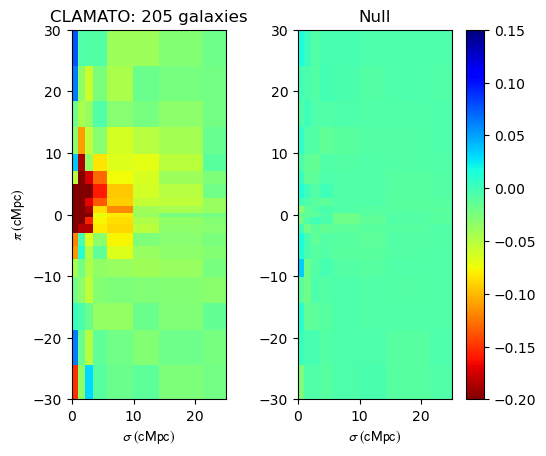

-0.006694491512605411


In [9]:
SigMax = 25.
PiMin = -30.
PiMax = 30.

fig, (ax1, ax2)= plt.subplots(1,2)

pcm=ax1.pcolormesh(X, Y, XCorrArr,cmap='jet_r',vmin=-0.2, vmax=0.15 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("CLAMATO: %i galaxies" % len(gal_clamato))

ax2.pcolormesh(X, Y, XCorrRand, cmap='jet_r',vmin=-0.2,vmax=0.15)
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_title("Null")

#fig.colorbar(pcm, ax=ax1)
fig.colorbar(pcm, ax=ax2)
fig.subplots_adjust(wspace=-0.2)

plt.show()

print(np.mean(XCorrRand))

### Compute Cross-Correlation For 3D-HST Galaxies

Evaluating cross-correlation for 322 galaxies and 95748 forest pixels
2D histogram evaluation took 0.014516 seconds for first galaxy
Finished evaluating cross-correlations. This took 3.909321 seconds
0 galaxies had no cross-correlations within these bins.


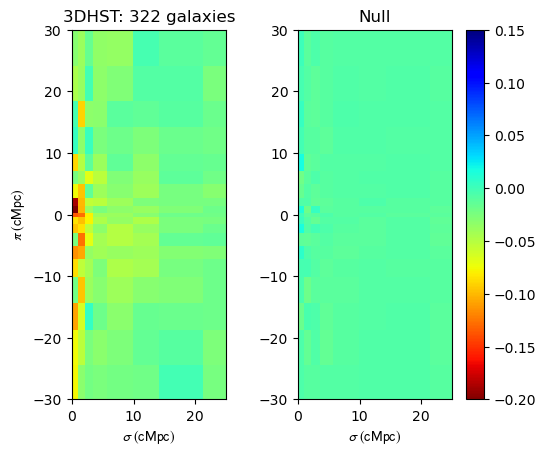

In [10]:
XCorr_3d, NoXCorr_3d = xcorr.xcorr_gal_lya(Coord_3d, lyapix, SigEdges, PiEdges, cosmo=cosmo)
XCorr_3d_rand, _ = xcorr.xcorr_gal_lya(Rand_3d, lyapix, SigEdges, PiEdges, cosmo=cosmo,verbose=0)

X, Y = np.meshgrid(SigEdges, PiEdges)

XCorrArr = np.rot90(XCorr_3d)
XCorrArr = np.flipud(XCorrArr)
XCorrRand = np.rot90(XCorr_3d_rand)
XCorrRand = np.flipud(XCorrRand)

SigMax = 25.
PiMin = -30.
PiMax = 30.

fig, (ax1, ax2)= plt.subplots(1,2)

pcm=ax1.pcolormesh(X, Y, XCorrArr,cmap='jet_r',vmin=-0.2, vmax=0.15 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("3DHST: %i galaxies" % len(gal_3d))

ax2.pcolormesh(X, Y, XCorrRand, cmap='jet_r',vmin=-0.2,vmax=0.15)
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_title("Null")

#fig.colorbar(pcm, ax=ax1)
fig.colorbar(pcm, ax=ax2)
fig.subplots_adjust(wspace=-0.2)

plt.show()

### Compute Cross-Correlations for VUDS galaxies

In [11]:
XCorr_vuds, NoXCorr_vuds = xcorr.xcorr_gal_lya(Coord_vuds, lyapix, SigEdges, PiEdges, cosmo=cosmo)
XCorr_vuds_rand, _ = xcorr.xcorr_gal_lya(Rand_vuds, lyapix, SigEdges, PiEdges, cosmo=cosmo,verbose=0)

X, Y = np.meshgrid(SigEdges, PiEdges)

XCorrArr = np.rot90(XCorr_vuds)
XCorrArr = np.flipud(XCorrArr)

XCorrRand = np.rot90(XCorr_vuds_rand)
XCorrRand = np.flipud(XCorrRand)

Evaluating cross-correlation for 469 galaxies and 95748 forest pixels
2D histogram evaluation took 0.013803 seconds for first galaxy
Finished evaluating cross-correlations. This took 5.393544 seconds
0 galaxies had no cross-correlations within these bins.


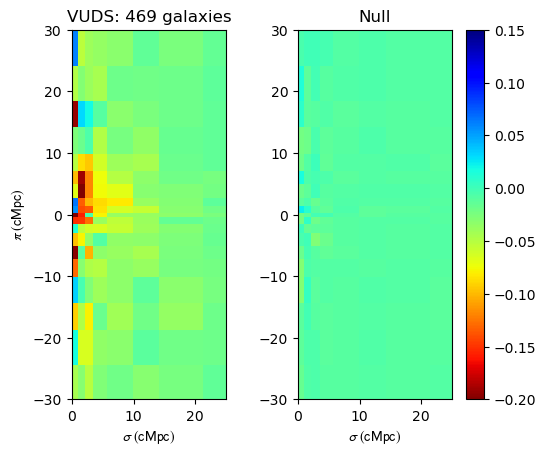

-0.00820185724415026


In [12]:
SigMax = 25.
PiMin = -30.
PiMax = 30.

fig, (ax1, ax2)= plt.subplots(1,2)

pcm=ax1.pcolormesh(X, Y, XCorrArr,cmap='jet_r',vmin=-0.2, vmax=0.15 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("VUDS: %i galaxies" % len(gal_vuds))

ax2.pcolormesh(X, Y, XCorrRand, cmap='jet_r',vmin=-0.2,vmax=0.15)
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_title("Null")

#fig.colorbar(pcm, ax=ax1)
fig.colorbar(pcm, ax=ax2)
fig.subplots_adjust(wspace=-0.2)

plt.show()

print(np.mean(XCorrRand))

### Compute Cross-Correlation for all galaxies

In [13]:
XCorr_all, NoXCorr_all = xcorr.xcorr_gal_lya(Coord_all, lyapix, SigEdges, PiEdges,cosmo=cosmo)
XCorr_all_rand, _ = xcorr.xcorr_gal_lya(Rand_all, lyapix, SigEdges, PiEdges,cosmo=cosmo,verbose=0)

X, Y = np.meshgrid(SigEdges, PiEdges)

XCorrArr = np.rot90(XCorr_all)
XCorrArr = np.flipud(XCorrArr)
XCorrRand = np.rot90(XCorr_all_rand)
XCorrRand = np.flipud(XCorrRand)

Evaluating cross-correlation for 2128 galaxies and 95748 forest pixels
2D histogram evaluation took 0.014080 seconds for first galaxy
Finished evaluating cross-correlations. This took 25.167545 seconds
0 galaxies had no cross-correlations within these bins.


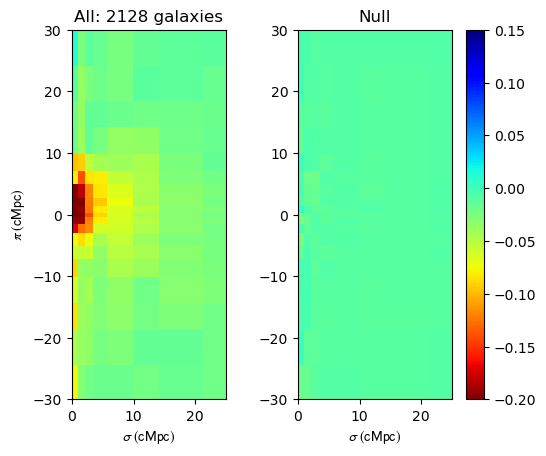

-0.008965614544181428


In [14]:
np.save(os.path.join(xcorr_dir_base, "xcorr_all_globalf_v4.1.npy"), XCorr_all.value)
np.save(os.path.join(xcorr_dir_base, "xcorr_rand_all_globalf_v4.1.npy"), XCorr_all_rand.value)

SigMax = 25.
PiMin = -30.
PiMax = 30.

fig, (ax1, ax2)= plt.subplots(1,2)

pcm=ax1.pcolormesh(X, Y, XCorrArr,cmap='jet_r',vmin=-0.2, vmax=0.15 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("All: %i galaxies" % len(gal))

ax2.pcolormesh(X, Y, XCorrRand, cmap='jet_r',vmin=-0.2,vmax=0.15)
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_title("Null")

#fig.colorbar(pcm, ax=ax1)
fig.colorbar(pcm, ax=ax2)
fig.subplots_adjust(wspace=-0.2)

plt.show()

print(np.mean(XCorrRand))

Plot all 4 galaxy samples side-by-side, and save all to file.

In [15]:
# Write to file in .npy format
np.save(os.path.join(xcorr_dir_base, "xcorr_3dhst_globalf_v4.1.npy"), XCorr_3d.value)
np.save(os.path.join(xcorr_dir_base, "xcorr_zDeep_globalf_v4.1.npy"), XCorr_zD.value)
np.save(os.path.join(xcorr_dir_base, "xcorr_mosdef_globalf_v4.1.npy"), XCorr_mosdef.value)
np.save(os.path.join(xcorr_dir_base, "xcorr_vuds_globalf_v4.1.npy"), XCorr_vuds.value)

np.save(os.path.join(xcorr_dir_base, "xcorr_rand_3dhst_globalf_v4.1.npy"), XCorr_3d_rand.value)
np.save(os.path.join(xcorr_dir_base, "xcorr_rand_zDeep_globalf_v4.1.npy"), XCorr_zD_rand.value)
np.save(os.path.join(xcorr_dir_base, "xcorr_rand_mosdef_globalf_v4.1.npy"), XCorr_mosdef_rand.value)
np.save(os.path.join(xcorr_dir_base, "xcorr_rand_vuds_globalf_v4,1.npy"), XCorr_vuds_rand.value)

In [16]:
np.save(os.path.join(xcorr_dir_base, "xcorr_clamato_globalf_v4.1.npy"), XCorr_clamato.value)
np.save(os.path.join(xcorr_dir_base, "xcorr_rand_clamato_globalf_v4.1.npy"), XCorr_clamato_rand.value)


Generate a few single-sample nulls to test covariance matrix

np.random.seed(seed=4321)

# MOSDEF randoms
gal_tmp = gal_mosdef
ra0_tmp = min(gal_tmp['ra'])
raran_tmp = max(gal_tmp['ra']) - min(gal_tmp['ra'])
dec0_tmp = min(gal_tmp['dec'])
decran_tmp = max(gal_tmp['dec']) - min(gal_tmp['dec'])
dist_tmp = cosmo.comoving_distance(gal_tmp['zspec'])
dist0_tmp = min(dist_tmp)
distran_tmp = max(dist_tmp) - min(dist_tmp)

for ii in range(0,3):
    ra_rand_tmp = np.random.random_sample(len(gal_tmp))*raran_tmp + ra0_tmp
    dec_rand_tmp = np.random.random_sample(len(gal_tmp))*decran_tmp + dec0_tmp
    dist_rand_tmp = np.random.random_sample(len(gal_tmp))*distran_tmp + dist0_tmp
    Rand_mosdef = SkyCoord(ra=ra_rand_tmp*u.degree, dec=dec_rand_tmp*u.degree, 
                   distance=dist_rand_tmp)
    XCorr_mosdef_rand, _ = xcorr.xcorr_gal_lya(Rand_mosdef, lyapix, SigEdges, PiEdges, cosmo=cosmo)
    filnam = "xcorr_rand{0:d}_mosdef_v0.npy".format(ii)
    np.save(os.path.join(xcorr_dir_base, filnam, XCorr_mosdef_rand)
    
# zDeep randoms
gal_tmp = gal_zD
ra0_tmp = min(gal_tmp['ra'])
raran_tmp = max(gal_tmp['ra']) - min(gal_tmp['ra'])
dec0_tmp = min(gal_tmp['dec'])
decran_tmp = max(gal_tmp['dec']) - min(gal_tmp['dec'])
dist_tmp = cosmo.comoving_distance(gal_tmp['zspec'])
dist0_tmp = min(dist_tmp)
distran_tmp = max(dist_tmp) - min(dist_tmp)

for ii in range(0,3):
    ra_rand_tmp = np.random.random_sample(len(gal_tmp))*raran_tmp + ra0_tmp
    dec_rand_tmp = np.random.random_sample(len(gal_tmp))*decran_tmp + dec0_tmp
    dist_rand_tmp = np.random.random_sample(len(gal_tmp))*distran_tmp + dist0_tmp
    Rand_zD = SkyCoord(ra=ra_rand_tmp*u.degree, dec=dec_rand_tmp*u.degree, 
                   distance=dist_rand_tmp)
    XCorr_zD_rand, _ = xcorr.xcorr_gal_lya(Rand_zD, lyapix, SigEdges, PiEdges, cosmo=cosmo)
    filnam = "xcorr_rand{0:d}_zDeep_v0.npy".format(ii)
    np.save(os.path.join(xcorr_dir_base, filnam, XCorr_zD_rand)